# Algorithmic Methods for Data Mining
### Group 8: Malick Alexandre Ngorovitch Sarr 1788832 , Livia Biggi 1793434, Giacomo Parmendola
### Homework 3

## 1. Data Collection

In [2]:
import string   
from langdetect import detect
from nltk.stem.snowball import EnglishStemmer  #We'll only work with songs in English
import nltk
from collections import defaultdict
from collections import Counter
import logging
import os
from bs4 import BeautifulSoup as soup
import pymongo
from pymongo import MongoClient
import time
import math   
import heapq
import sklearn.metrics.pairwise
import numpy as np
from scipy import spatial
import heapq
import wordcloud
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [2]:
import nltk

### Mlab Login Infos

In [3]:
'''
Input your MongoDB Connetion details in this field 
'''
DB_NAME = "adm_hw3"  
DB_HOST = "ds117136.mlab.com" 
DB_PORT = 17136
DB_USER = "liviab" 
DB_PASS = "fonta13"


connection = MongoClient(DB_HOST, DB_PORT)
db = connection[DB_NAME]
db.authenticate(DB_USER, DB_PASS)

True

### Getting Songs and Upload to Mongo DB

In [4]:
#define the punctuation that needs to be removed from the lyrics
punctuation_symbols = dict((ord(char), None) for char in string.punctuation)

#define the stemmer of English words
stemmer = EnglishStemmer()

#define the variable stopwords as a list of English stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

#get the details of the song
def getDetails(soup, url):
    #take the song header in which we extract the name and the artist
    temp= soup.find('h2', {'class': 'lyric-song-head'}).text.rsplit(' ', 1)[0].split(" – ")
    artist = temp[0]; title = temp[1]
    #extract the lyrics
    lyrics = str(soup.find('div', {'class': 'dn'})).replace('<div class="dn" id="content_h">', '').replace('<br/>', ' ').replace('</div>', '')    
    #transform the words of the lyrics into stemmed tokens (w/o including stopwords)
    tokens = [EnglishStemmer().stem(t.lower()).translate(punctuation_symbols) for t in nltk.word_tokenize(lyrics) if t.lower() not in stopwords]
    
    details = {'artist': artist}
    details['title'] = title
    details['lyrics'] = lyrics
    details['url'] = url
    details['tokens']= tokens
       
    return details

In [ ]:
path = r"C:\Users\livia\Desktop\ADM_HM3\lyrics_collection"
count= 0
#takes each file within the directory and uploads it to a collection in MongoDB
for filename in os.listdir(path):
        count+=1
    #subpath get the path of the file within the directory 
        subpath = os.path.join(path, filename) 
        #run BeautifulSoup to extract the contents
        try:
            soup_ = soup(open(subpath,encoding="utf-8"), "html.parser")
            record = getDetails(soup_,filename)
            #read the html pages using BeautifulSoup and check that the lyrics is in English
            if detect(record["lyrics"]) != "en":
                continue
            #upload the songs to mLab, assigning a specific _id to each song (count)
            db.lyrics.insert_one({"_id": count,"details": record})
        except:
            pass          
        

## 3. Search Engine

### Inverted Index

In [5]:
#given the structure of the files on mLab, the total number of songs is just the length of the collection
totalSongs = 71942 #len(list(db.lyrics.find()))

In [6]:
#create the inverted index for every word of every song in the lyrics collection on mLab

#for the songs in the collection, create a dictionary (tokens) that counts the tokens for each song
for item in list(db.lyrics.find()):
    token = Counter(item["details"]["tokens"])
    #calculate the number of words in each song
    totalWords = sum(token.values())

    #upload the inverted index to a new collection on mLab
    for word, frequency in token.items():
            db.inv_index.update_one({ "word": word}, 
                                { "$push": {"value": (item["_id"],(frequency, totalWords))}}, upsert= True)
                

KeyboardInterrupt: 

In [6]:
#Calculate the Inverse Document Frequency
def inverseDocumentFrequency(term, totalDocuments):
    if len(list(db.inv_index.find({"word": str(term)}))) > 0:
        docs_with_term = len(list(db.inv_index.find({"word": str(term)}))[0]["value"])
        return 1.0 + math.log(totalDocuments/docs_with_term)
    else: 
        return 1.0

### Compute the Tf-Idf Cosine Similarity for the Query

In [7]:
def processQuery(query):
    #clean the query >> tokenise it, make all words lower-case, stem them and remove stopwords >> set() 
    query = [EnglishStemmer().stem(t.lower()).translate(punctuation_symbols) for t in nltk.word_tokenize(query) if t.lower() not in stopwords  and len(t) > 1]
    #create an empty array that will be filled with the tf-idf of the query
    tfidf_query = []
    #store the count of each word in the query into a dictionary
    countWord = dict(Counter(query))
    #define the total number of words in the query
    tot_words = sum(countWord.values())

    for key ,value in countWord.items():
        tfidf_score = (value/tot_words)*inverseDocumentFrequency(key, totalSongs)
        tfidf_query.append(tfidf_score)

    #define a vectorised query as the numpy array of the tf-idf query
    global vect_query
    vect_query = np.array(tfidf_query)

    vect_query.shape #the shape of the vectorised query will be the same as the number of words in the query

    #compute the distance between the query and each song
    #create a document set that we fill with zeros, the zeros will represent the documents that do not contain a particular word

    docs = {}
    #for each word in the query, check if the word is in the database collection (inverted index)
    #if it is, skip it (to avoid having duplicate values), otherwise add it
    #the rationale behind this is that you want arrays of identical shapes in order to compare them

    for word in query:    
        #grab the values associated with the word 
        for element in list(db.inv_index.find({"word": word}))[0]["value"]: #in the inverted index collection
            if element[0] in docs:
                continue
            else:
                song_tfidf = np.zeros(vect_query.shape) #set the variable as an empty array with the same shape as the vector query
                docs[element[0]] = song_tfidf

    #build the tf-idf for the term and its corresponding document
    #a pointer is used to identify the term that's being added to the array
    pointer = -1
    for term in query:
        pointer += 1
        idf = inverseDocumentFrequency(term, totalSongs) #get the idf of the document

        for item in list(db.inv_index.find({"word": term}))[0]["value"]: #in the inverted index collection
            #since we want to work with a normalised tf, we divide it by the total number of words in each lyrics and then
            #multiply it by the idf, in order to the tf-idf score of each song
            #tf / total number of words in lyrics * idf
            song_tfidf = (item[1][0]/item[1][1])*idf #tf-idf of the song
            docs[item[0]][pointer]= song_tfidf

    return docs

### Search Engine: Type 1

#### Obtain the top 10 most relevant songs

In [8]:
def runType1(docs):
    songResult = []
    #now that we have a dictionary of terms with their corresponding tf-idf, we just need to compare it to the query

    for song, score in docs.items():
        #vect_query is the normalised query and the score is the array with idf of each song
        cos_sim = 1 - spatial.distance.cosine(vect_query, score) #cosine similarity between the query and each song

        #if there are less than 10 songs containing the query terms, we push the songs into the heap
        if len(songResult) <= 9: 
            heapq.heapify(songResult)
            heapq.heappush(songResult,(cos_sim, song))

        #if there are over 10 songs containing the query terms, pick the ones with the highest similarity
        else:
            #if the new score (idf) is higher than the minimum frequency of the heap, we pop it and replace with the higher
            #value we just found
            if songResult[0][0] < cos_sim:#replace the smaller value
                    heapq.heapreplace(songResult,(cos_sim, song))
            else:
                    continue

    topTen = []
    while len(songResult) > 0:
        topTen.append(heapq.heappop(songResult))

    print("Top 10 Artists:")
    for song in reversed(topTen):
        print(db.lyrics.find_one({'_id' : song[1]} )['details']['artist']," - ", db.lyrics.find_one({'_id' : song[1]} )['details']['title'])

### Search Engine: Type 2

In [9]:
#define a function that picks a random colour (hue) for the words in the wordcloud
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    #hue values are in the range 0-360
    hue = int(360.0 * float(random_state.randint(0, 360)) / 255.0)
    saturation = int(100.0 * 255.0 / 255.0)
    luminosity = int(100.0 * 80 / 255.0)
    return "hsl({}, {}%, {}%)".format(hue, saturation, luminosity)

def create_wordcloud(text):
# Display the generated image:
# the matplotlib way:
    wordcloud = WordCloud(background_color="white", max_words=200, stopwords=stopwords, max_font_size=40, color_func=random_color_func).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [10]:
def plotKmean(x,y,C):
    plt.scatter(x, y, c=C, s=50,cmap='viridis')
    plt.show()

In [11]:
def plotKmean3D(x,y,z,C):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=C, s=50, cmap='viridis')
    plt.show()

In [12]:
def runType2(docs,k):
#create a dictionary of the documents that contain all terms in the query (i.e. the conjunctive query)
    conj_songs={}
    for key ,value in docs.items():
        #pick only the songs that contain all terms >> skip the songs that have 0s as their tf-idf values for any of the query terms
        if docs[key].__contains__(0):
            continue
        else:
            conj_songs[key]= value
    
    if bool(conj_songs) == False: 
        print('No song containing the terms')
        return
    #create a feature vector that contains the tf-idf scores of the songs containing all query terms
    X = []
    for key, value in conj_songs.items():
        X.append(value)
    feat_vect = np.array(X)



    #create a k-means instance, where the user inputs the number of clusters
    kmeans = KMeans(n_clusters = int(k), init='k-means++')
    kmeans.fit(feat_vect)

    #identify in which cluster each song belongs to
    clusterResults = {}

    for key, value in conj_songs.items():
        if kmeans.predict([conj_songs[key]])[0] not in clusterResults:
            clusterResults[int(kmeans.predict([conj_songs[key]])[0])] = [key]
        else:
            clusterResults[int(kmeans.predict([conj_songs[key]])[0])].append(key)
            
    if np.shape(feat_vect)[1] == 2 : 
        plotKmean(feat_vect[:, 0], feat_vect[:, 1], kmeans.predict(feat_vect))
    if np.shape(feat_vect)[1] == 3 :
        plotKmean3D(feat_vect[:, 0], feat_vect[:, 1],feat_vect[:, 2], kmeans.predict(feat_vect))
    print("visual representation of cluster")
    
    print("Repartition of the songs according to their respective cluster")
    print(clusterResults)       
    for key, value in clusterResults.items():
        text = ''
        artistList = []
        for song in value:
            text += list(db.lyrics.find({"_id": song}))[0]['details']["lyrics"]
            artistList.append((list(db.lyrics.find({"_id": song}))[0]['details']["artist"],list(db.lyrics.find({"_id": song}))[0]['details']["title"]))
        print("details:", artistList )
        create_wordcloud(text)

## Search Engine

In [ ]:
print("Search: ")
query = input() 
q = processQuery(query)
print("Select 1 for the most relevant songs")
print("Select 2 for all songs containing all search words")
print("Select 3 to change search words")
print("Select 0 to Exit")

choice = input()
while choice != "0":
    if choice == "1":
        runType1(q)
        choice= input()
    elif choice =="2":
        print("Number of clusters:")
        k= input()
        runType2(q,k)
        choice= input()
    elif choice == "3":
        query = input()
        q = processQuery(query)
    elif choice == "0":
        break
    else:
        print("Invalid Value: Please enter a valid number")
        choice = input()

Search: 
bells hell
Select 1 for the most relevant songs
Select 2 for all songs containing all search words
Select 3 to change search words
Select 0 to Exit
1
Top 10 Artists:
Fun Lovin' Criminals  -  All My Time Is Gone
Volbeat  -  A Warrior's Call
Eminem  -  A Kiss
10cc  -  24 Hours
Wrestling Lyrics  -  Anthrax & Public Enemy- "Bring Da Noise"
Don McLean  -  American Pie
Lou Reed  -  All Through The Night
Tom Waits  -  Ain't Goin' Down To The Well
Violent Femmes  -  Bad Dream
Jimi Hendrix  -  Ball And Chain For Sale


## 2. Song Statistics

### 2.1 Most Popular Artist

In [4]:
#create a list of tuples containing the artist name and the number (count) of his/her songs
allArtists = []
for artist in db.lyrics.distinct("details.artist"): 
    allArtists.append((artist, db.lyrics.find({"details.artist" : artist}).count()))
#sort the list by popularity (i.e. number of songs) in descendant order
allArtists.sort(key=lambda x: x[1])
allArtists.reverse()
print("The most popular artist is", allArtists[0][0], "with", allArtists[0][1], "songs")

The most popular artist is Elton John with 207 songs


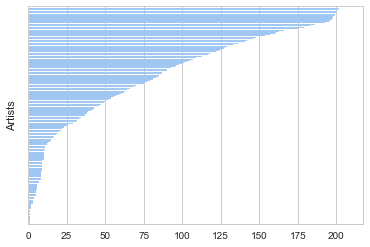

In [8]:
#create the histogram of the number of songs per artist
sns.set(style = "whitegrid")
x = [name for name, songs in allArtists]
y = [songs for name, songs in allArtists]
sns.set_color_codes("pastel")
sns.barplot(x = y, y = x, label="Songs per Artist", color="b")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
#hide the names of the artists from the chart, since it'd make it unreadable
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
plt.ylabel("Artists")
plt.show()

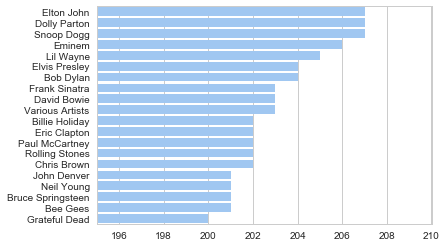

In [31]:
#create the histogram of the number of songs of the 20 most popular artists
sns.set(style = "whitegrid")
x = [name for name, songs in allArtists[0:20]]
y = [songs for name, songs in allArtists[0:20]]
sns.set_color_codes("pastel")
sns.barplot(x = y, y = x, label="Songs per Artist", color="b")
plt.xlim(195,210)
plt.show()


The histograms above aim to illustrate the success of each artist, by considering the amount of songs he/she has composed throughout the years. This visual representation appears problematic in determining their degree of popularity, as it does not take into account each artist's individual years of activity, but rather, it only considers their records. For this reason, it is not surprising that the singers and bands who have produced the most songs are also the ones who have been active the longest. As a matter of fact, Elton John is shown to have composed the most songs (207), followed by equally long-running artists, such as Bruce Springsteen and Paul McCartney (who have been active since 1964 and 1957, respectively), as well as the late Frank Sinatra, who was active for 60 years. As previously mentioned, the data analysed here do not include several songs from the original database, which is why some extremely successful artists do not show up in the statistics of the 20 most popular singers and bands, such as Prince.

Furthermore, the presence in the industry may not be the only factor to determine how many songs each artist has composed, but it could also be due to other reasons, such as the time they were active. This possibly relates to the cultural movements involved in the evolution of the music industry: as trends come and go, artists are associated with different genres of music, which might mean that more recent singers who produce today's most popular music also tend to compose more songs, and thus appear in the histogram (e.g. Eminem and Lil Wayne, who have only been producing music since the 1990s).

A possible explanation for the occurrence of more recent singers in the ranking could be related to the recent technological advances, that have made it easier and quicker for artists to compose music. In conclusion, the most successful singers and bands are expected to be a melting pot of artists from different historical periods and diverse genres, and not necessarily the oldest figures in the music industry.


### 2.2 Most popular words

In [40]:
#create a list of all words in every song, then clean them (i.e. stem them, remove stopwords and empty spaces)
stopwords = set(nltk.corpus.stopwords.words('english'))             

allWords = []
for song in db.lyrics.find(): 
    allWords.extend(song['details']['tokens'])
wordCount = Counter(list(filter(lambda word: len(word) > 1 and word not in stopwords, allWords)))
for element in wordCount.most_common(20):
    print(element[0],":", element[1])

nt : 228996
love : 129937
know : 102473
like : 90968
got : 87444
oh : 75097
get : 74058
go : 70903
come : 65321
na : 64508
time : 62202
one : 59921
want : 59885
babi : 56407
let : 55372
see : 55358
say : 51629
never : 50416
make : 50229
feel : 47594


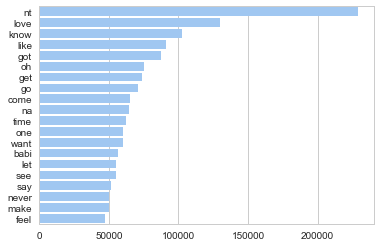

In [41]:
#create the histogram of the 20 most frequent words in the songs of the collection
sns.set(style = "whitegrid")
x = [word for word, count in wordCount.most_common(20)]
y = [count for word, count in wordCount.most_common(20)]
sns.set_color_codes("pastel")
sns.barplot(x = y, y = x, label="Most Frequent Words", color="b")
plt.show()

The database analysed contains 71,942 songs, in which the most common 20 are the ones displayed above. As for any other form of art, the most representative words in the results are related to feelings (e.g. "love", "want", "see", "like", "feel"), ranging between approximately 50,000 and 130,000 times repetitions each in the database. Although the words have been tokenised and stemmed, some of them might not have been considered stopwords by the stopwords library and thus they have not been removed. This is the case for the top result, "nt", which derives from some truncated English negative expressions (e.g. "aren't", "isn't", "ain't", "can't", etc.), and that does not have any intrinsic meaning by itself. Unsurprisingly, "love" appears the most in the database analysed, followed by expressions that are now largely popular and spread in contemporary commercial pop music (e.g. "baby), or that are common simple constructs of the English language (e.g. "get").

### 2.3 Most popular first names

In [42]:
#create a list of the full names of all artists, then select each firstname in order to find the 10 most common ones
artistName = []
for song in db.lyrics.find():  
    artistName.append(song["details"]["artist"])
nameCount = Counter([name.split()[0] for name in set(artistName)])    
for element in nameCount.most_common(10):
    print(element[0],":", element[1])

The : 26
Tom : 6
David : 5
Steve : 5
Queen : 5
Hillsong : 4
John : 4
George : 4
Frank : 4
Will : 4


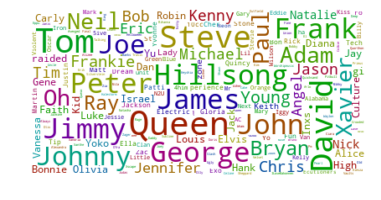

In [45]:
#create a wordcloud of the first names of the artists
ten_names = ""
ten_names += " ".join([name.split()[0] for name in set(artistName)])
create_wordcloud(ten_names)

The wordcloud above shows the most common artist first names, out of the dataset analysed.
The most striking feature of this visual representation, is that the vast majority of these names belongs to men; feminine names indeed appear sporadically and often have a smaller size than the masculine names (i.e. they are much less frequent).
Although the original database contained approximately 86,000 songs, this Search Engine analysed only the songs written in English (about 72,000). This transformation of the original pool of artists might alter the displayed results up to a certain point: the pool of data used for this analysis is only 16% smaller than the original database, and hence does not largely affect the results shown. As a matter of fact, all names in the wordcloud are either American or English, demonstrating a prevalence of Anglo-saxon culture in contemporary music.
Finally, the most interesting aspect of the list of the top 10 first names is that "The" appears in the first place, showing that bands are more common than individual singers. The database indeed contains 26 bands whose name starts with "The" (excluding those whose name does not contain the article, e.g. Queen).

### 2.4 Songs Lengths

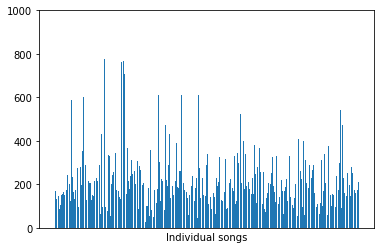

In [7]:
#create a histogram with the length of each song

wordCount = [] #array that stores the count of lyrics for each song
tokens = db.lyrics.find()
#for every song in our list, we will count the number of tokens
for w in tokens:
    wordCount.append(len(w['details']['lyrics'].split()))
#we create a np array that we fill with the total number of songs
X= np.arange(len(wordCount))
plt.bar(X,wordCount)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') #
plt.ylim(0,1000)
plt.xlabel("Individual songs")
plt.show()

The histogram illustrates that the average length of songs in the data is approximately 150 words. The shortest song has as little as 4 words, which might be due to the fact that it is mostly instrumental. On the other hand, the maximum song length is identified in compositions of as much as 800 words; which could be due to either the genre of the song or the period in which it was written. As a matter of fact, one of the most striking features of the evolution of the music industry is that older songs tended to have longer lyrics, whilst more recent ones play on the repetition effect (i.e. they present longer choruses and less instrumental parts). The chart shows that the average length of the song is about 220 words which might represent the optimal balance between instrumental and sung parts. 